In [44]:
# This notebook was partially inspired by
# https://www.kaggle.com/tanmayunhale/titanic-top-4-hyperparameter-tuning/notebook
# https://www.kaggle.com/himanshusirsat/titanic-ml

import re
import numpy as np # linear algebra
from sklearn.model_selection import GridSearchCV
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

print('Done')

Done


# Introductory Materials

visualization of the ship evacuation process: https://www.youtube.com/watch?v=03IAn3TXVOc
Titanic Deckplans: https://www.encyclopedia-titanica.org/titanic-deckplans/

on the above video reconstruction we can see that the crew was strictly ordered to evacuate women and children first.
On the deckplans we can see that 3rd class decks were located below class 1 decks.


In [45]:
# Gathering train and test data
XTRAIN = pd.read_csv("input/train.csv")
XTEST = pd.read_csv("input/test.csv")


# Exploring the Data, planning the preprocessing

So, in training data we have 891 records with 12 columns.
5 of them consist text data

## Looking at missing data
a lot of missing data in column Cabin, also some missing in Age


In [46]:
XTRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


for the test data we can see that there is less missing data than in train data
but also we have only 418 records and 11 cols (no 'Survival')

In [47]:
XTEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Sex
Most of the passengers were male

<AxesSubplot:xlabel='Sex', ylabel='count'>

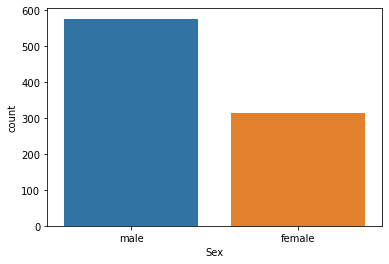

In [48]:
sns.countplot(x="Sex",data=XTRAIN)

## Parch - parent / child
Most of them werent with their parents or children

<AxesSubplot:xlabel='Parch', ylabel='count'>

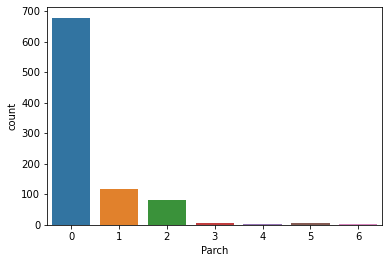

In [49]:
sns.countplot(x="Parch",data=XTRAIN)

## SibSp - Siblings / Spouses
Also, most of them didnt have any siblings on spouses

<AxesSubplot:xlabel='SibSp', ylabel='count'>

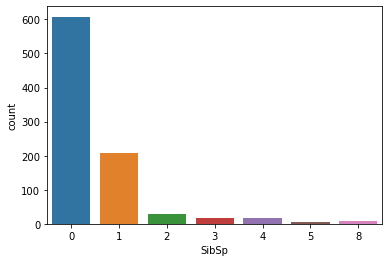

In [50]:
sns.countplot(x="SibSp",data=XTRAIN)

## Pclass
The majority of passengers were travelling in class 3

<AxesSubplot:xlabel='Pclass', ylabel='count'>

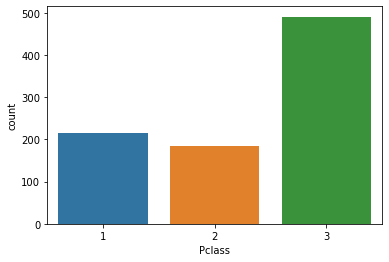

In [51]:
sns.countplot(x="Pclass",data=XTRAIN)

## Fare (opłata)
We can see 3 main Fare groups, most of them in low and medium Fare range

In [52]:
sns.countplot(x="Fare",data=XTRAIN)

<AxesSubplot:xlabel='Fare', ylabel='count'>

Error in callback <function flush_figures at 0x7f8c132af700> (for post_execute):


KeyboardInterrupt: 

## Embarked (zaokrętowanie)
Most of the passengers went from Southampton
Embarked column consists name for one of the cities the Titanic embarked in: S - Southampton, C - Cherbourg, Q - Queenstown

<AxesSubplot:xlabel='Embarked', ylabel='count'>

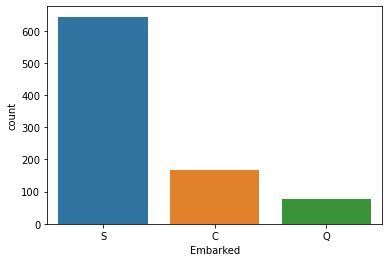

In [53]:
sns.countplot(x="Embarked",data=XTRAIN)

## Age
The variety of passengers Age - most of them in their mid age

<AxesSubplot:xlabel='Age', ylabel='count'>

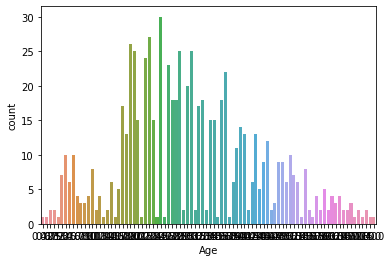

In [54]:
sns.countplot(x="Age",data=XTRAIN)

# Correlations between data

We are most interested in correlation with Survived column:
- Pclass: negative correlation suggests that most of the victims were in 3rd class, and most survivals were in 1st class
- Fare: positive correlation suggests that the more passenger paid the more likely he survived

- There are also some redundant correlations between other columns (redundancy / nadmarowość):
- Pclass vs Fare: these 2 columns seems to have negatively correlated data
- Pclass vs Age negative correlation suggests that 1st class passengers were the oldest ones
- Age vs SibSp neg correlation suggests that number of siblings / spouses was higher for younger passengers
- SibSp vs Parch correlation suggests that the more siblings / spouses the more parents / children
- Parch vs Fare correlation also suggests that families paid higher price for tickets
The redundancy needs to be taken care of as we want features data to be as unique as possible

<AxesSubplot:>

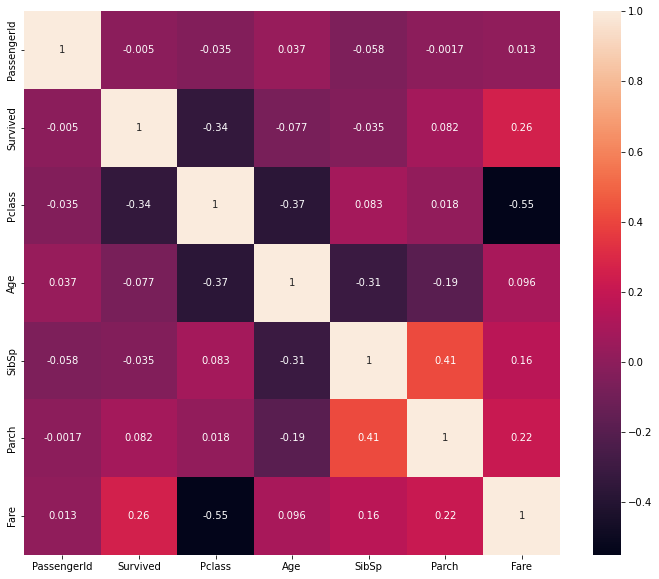

In [55]:
# Heatmap
data_correlations = XTRAIN.corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data_correlations, annot=True)

## Sex vs Survived
The majority of the victims were male
The majority of survivers were women
That's because women and children took priority in evacuation by the captain orders

<AxesSubplot:xlabel='Sex', ylabel='count'>

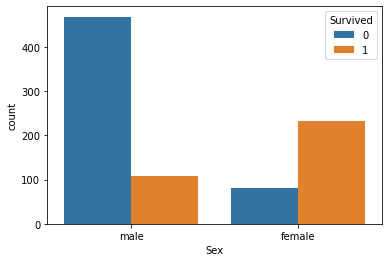

In [56]:
sns.countplot(x="Sex",hue="Survived",data=XTRAIN)

## Fare vs Survived
Most victims are those who paid low prices

<AxesSubplot:xlabel='Fare', ylabel='count'>

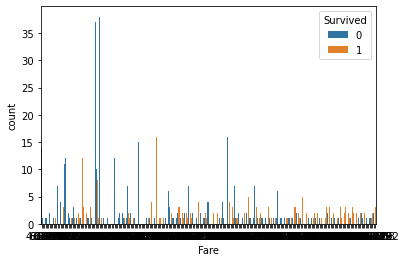

In [57]:
sns.countplot(x="Fare",hue="Survived",data=XTRAIN)

# the lower Fare

## Pclass vs Survived
mostly people from 3rd class died
these data is much cleaner than Fare and shows the same correlation

<AxesSubplot:xlabel='Pclass', ylabel='count'>

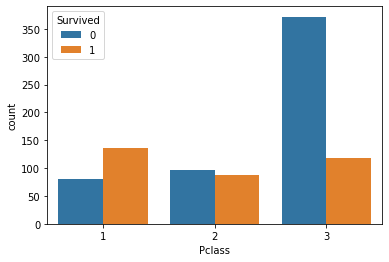

In [58]:
sns.countplot(x="Pclass",hue="Survived",data=XTRAIN)

## SibSp vs Survived
most of victims were nor siblings or spouses

<AxesSubplot:xlabel='SibSp', ylabel='count'>

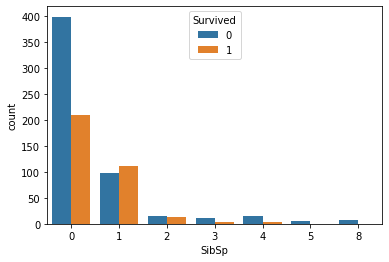

In [59]:
sns.countplot(x="SibSp",hue="Survived",data=XTRAIN)

## Age vs Survived
Most of the victims were young or mid-aged

<AxesSubplot:xlabel='Age', ylabel='count'>

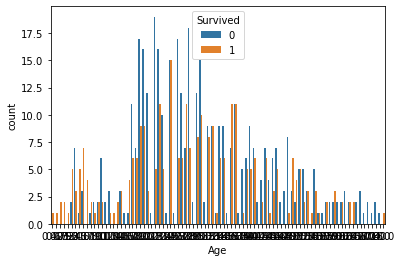

In [60]:
sns.countplot(x="Age",hue="Survived",data=XTRAIN)

In [61]:
XTRAIN.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing, Categorical & Not Useful Data

Let's see more details about nulls:
Cabin - has only 210 not-null records (out of 891), so we should drop it as not helpful.
Age - has some missing data, let's fill that up with an average of it
Embarked - we can drop these 2 records

In [62]:
XTRAIN.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

for the test data we have similar situation with Age,
also 1 Fare record is missing, will drop that one.

In [63]:
XTEST.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Also, columns: Ticket, Name will be dropped as they have only unique strings, so they can't become Categorical columns
Sex, Embarked - will be converted to Categorical

In [64]:
XTRAIN.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Same for the test data:

In [65]:
XTEST.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


Let's see what we can do with missing Embarked values.
Below you can see that the most frequent value is 'S'.
Let's fill empty Embarked values with 'S' as this is the most common one.

In [66]:
XTRAIN.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Same for the test data:

In [67]:
XTEST.Embarked.value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64


# Data Processing


In [68]:
# let's define a function that will do all the preprocessing discussed above
def preprocess_data(df):
    # replace empty ages with an average
    df['Age'].fillna(df["Age"].mean(), inplace=True)

    # fill missing embarked values with the most common one
    df['Embarked'].fillna('S', inplace=True)

    # we don't need whole age, as experiments show that age < 18
    # is most important for survival
    df["is_child"] = df["Age"]<18

    # dropping rows with empty records
    df.dropna(inplace=True)
    
    # converting Categorical cols into numbers
    df = pd.get_dummies(df, columns=["Pclass", "Embarked", "Sex", "is_child"])

    # better column naming
    df["is_woman"] = df["Sex_female"]
    df["is_child"] = df["is_child_True"]

    # "Pclass_2", "Pclass_3" are neg correlated to Pclass_1 but the previous experiments shown that removing them
    # makes results worse - so we are leaving it
    df.drop(['Name', 'Cabin', 'Ticket', 'Sex_female', 'Sex_male', 'Age', 'SibSp', 'Parch'], axis='columns', inplace=True)
    df.drop(['Embarked_Q', "Embarked_C", "is_child_True", "is_child_False"], axis='columns', inplace=True)

    return df


# Let's run the preprocessing on both train and test data
X = preprocess_data(XTRAIN)
XTEST = preprocess_data(XTEST)

# we will need this column for results submission
PassengerColumn = XTEST.PassengerId

X.drop(['PassengerId'], axis='columns', inplace=True)
XTEST.drop(['PassengerId'], axis='columns', inplace=True)


As we can see, the columns structure is much more meaningful and clear now:

In [69]:
X.head()

,Survived,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_S,is_woman,is_child
1,1,71.2833,1,0,0,0,1,0
3,1,53.1000,1,0,0,1,1,0
6,0,51.8625,1,0,0,1,0,0
10,1,16.7000,0,0,1,1,1,1
11,1,26.5500,1,0,0,1,1,0


Also, there are no nulls:

In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 889
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    204 non-null    int64  
 1   Fare        204 non-null    float64
 2   Pclass_1    204 non-null    uint8  
 3   Pclass_2    204 non-null    uint8  
 4   Pclass_3    204 non-null    uint8  
 5   Embarked_S  204 non-null    uint8  
 6   is_woman    204 non-null    uint8  
 7   is_child    204 non-null    uint8  
dtypes: float64(1), int64(1), uint8(6)
memory usage: 6.0 KB


In [71]:
X.isnull().sum()

Survived      0
Fare          0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_S    0
is_woman      0
is_child      0
dtype: int64

In [72]:
XTEST.isnull().sum()

Fare          0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_S    0
is_woman      0
is_child      0
dtype: int64


# Post-Processing Data Analysis


- Survived vs is_woman 55% neg correlation
- is_child vs Survival 16% positive correlation
- Embarked_S vs Survived neg 12% corr
- scale_fare vs Survival 13% corr

KeyboardInterrupt: 

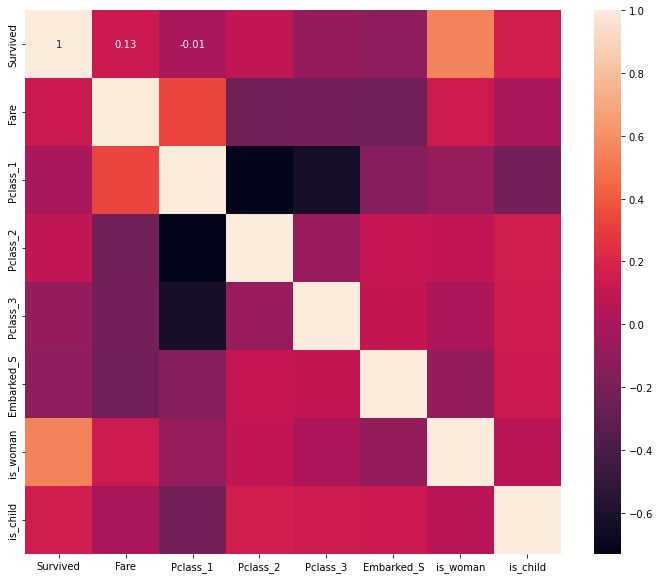

In [73]:
# Heatmap
plt.subplots(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True)

# Preparing for Model Training

## Separating target from features

In [ ]:
y = X['Survived']
X = X.drop(['Survived'], axis=1)
X.info()

## Splitting train data into train & validation data
as we can see the number of records in train data is lowered

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train.info()

# Models Training & Hyper-params Tuning for Different Classification Models

Some example results:

    # Best params: {'leaf_size': 25, 'n_neighbors': 7}
    # Best score: 0.6806818181818182    # {
    #     'model': KNeighborsClassifier(),
    #     'hyperparams': {
    #         'n_neighbors': range(16, 20, 1),
    #         'n_jobs': range(4, 5, 1)
    #     }
    # },
    # {
    #     'model': DecisionTreeClassifier(),
    #     'hyperparams': {
    #         'max_depth': [1, 2, 3, 4, 5]
    #     }
    # },
    # Best params: {'C': 0.7, 'penalty': 'l2'}
    # Best score: 0.7729166666666666    # {
    #     'model': LogisticRegression(solver='liblinear'),
    #     'hyperparams': {
    #         'penalty': ['l1', 'l2'],
    #         'C': [0.7, 0.8, 0.9, 1]
    #     }
    # },
    # Params:  {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'n_jobs': 4}
    # Mean score:  0.7852272727272728
    # {
    #     'model': RandomForestClassifier(n_jobs=4, max_features="auto", bootstrap=False),
    #     'hyperparams': {
    #         'criterion' :['gini', 'entropy'],
    #         'n_estimators': range(100, 300, 50),
    #         'n_jobs': range(4, 5, 1),
    #         'max_depth': range(6, 9, 1)
    #     }
    # },
    # Params:  {'criterion': 'friedman_mse', 'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 700}
    # Mean score:  0.8287878787878789    # {
    #     'model': GradientBoostingClassifier(random_state=0, max_features="auto"),
    #     'hyperparams': {
    #         'criterion': ['friedman_mse', 'mse', 'mae'],
    #         'n_estimators': range(250, 800, 50),
    #         'learning_rate': np.arange(0.02, 0.05, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },
    # Params:  {'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 700, 'validation_fraction': 0.2}
    # Mean score:  0.8287878787878789
    # {
    #     'model': GradientBoostingClassifier(criterion='friedman_mse', random_state=0, max_features="auto"),
    #     'hyperparams': {
    #         'validation_fraction': np.arange(0.2, 1, 0.5),
    #         'n_estimators': range(650, 900, 50),
    #         'learning_rate': np.arange(0.02, 0.035, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },
    # Model:  SVC
    # Params:  {'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear', 'max_iter': -0.1, 'shrinking': True}
    # Mean score:  0.66875
    # {
    #     'model': SVC(probability=True, kernel='linear'),
    #     'hyperparams': {
    #         'max_iter': [-0.1, 0.1, 0.2],
    #         'decision_function_shape': ['ovo', 'ovr'],
    #         'shrinking': [True, False],
    #         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #         'C': [0.1, 0.5, 1]
    #     }
    # },
    # Model:  GradientBoostingClassifier
    # Params:  {'learning_rate': 0.019999999999999997, 'max_depth': 4, 'n_estimators': 1150, 'validation_fraction': 0.15000000000000002}
    # Mean score:  0.8287878787878789
    # {
    #     'model': GradientBoostingClassifier(),
    #     'hyperparams': {
    #         'validation_fraction': np.arange(0.05, 0.3, 0.05),
    #         'n_estimators': range(850, 1200, 50),
    #         'learning_rate': np.arange(0.01, 0.03, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # }
    # Model:  GradientBoostingClassifier
    # Params:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1500}
    # Mean score:  0.8287878787878789
    # {
    #     'model': GradientBoostingClassifier(validation_fraction=0.15),
    #     'hyperparams': {
    #         'n_estimators': range(1200, 1700, 50),
    #         'learning_rate': np.arange(0.005, 0.02, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },



In [ ]:
# Ensemble Machine Learning Approach
# https://www.datacamp.com/community/tutorials/adaboost-classifier-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9061060&gclid=CjwKCAiA_omPBhBBEiwAcg7smbQQMeHghK-VyfEArRtCwA53E1PErY_NcMUYp7qCJNy_hRerXLHf9RoC4aUQAvD_BwE

# from sklearn.svm import SVC
# svc=SVC(probability=True, kernel='linear')
from sklearn.linear_model import LogisticRegression
from libs.simple_processing import get_model_name
# from sklearn.neighbors import KNeighborsClassifier

params = [
    {
        # possible to experiment with different solvers and max_iter param
        'model': LogisticRegression(solver='liblinear', max_iter=1000, fit_intercept=True),
        'hyperparams': {
            'penalty': ['l1', 'l2'],
            'C': [0.7, 0.8, 0.9, 1]
        }
    },
    {
        'model': GradientBoostingClassifier(random_state=0, max_features="auto", criterion='friedman_mse'),
        'hyperparams': {
            'n_estimators': range(250, 400, 50),
            'learning_rate': np.arange(0.02, 0.05, 0.005),
            'max_depth': range(4, 7, 1)
        }
    }
]

grid_model = {}

# also tried to use cv=4 and 6-15 but it made results worse
for p in params:
    print('> Model:', get_model_name(p['model']))
    grid_model = GridSearchCV(p['model'], p['hyperparams'], cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
    grid_model.fit(X_train, y_train)
    print('Best params:', grid_model.best_params_)
    print('Best score:', grid_model.best_score_)

# Best params: {'learning_rate': 0.04000000000000001, 'max_depth': 5, 'n_estimators': 350}
# Best score: 0.8285984848484848
print('Done.')

# Hyper-params Tuning Summary
Best performing model is GradientBoostingClassifier with accuracy score around 82,8%

## The Winner

In [ ]:
# model = GradientBoostingClassifier(**grid_model.best_params_)
model = GradientBoostingClassifier(learning_rate=0.04000000000000001, max_depth=5, n_estimators=350)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
pred_results = pd.DataFrame({'y_valid' : y_valid, 'y_pred': y_pred})

pred_results.head(10)

## Receiver Operating Characteristic (ROC)

In [ ]:
from libs.simpleplotter import *

simple_roc(y_valid, y_pred)

## Confusion Matrix / Macierz pomyłek

Now, let's take a look at the results

In [ ]:
conf_matrix = simple_confusion_matrix(y_valid, y_pred, model.classes_)

In [ ]:
# crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_valid)
print('TP:', conf_matrix[1][1])
print('TN:', conf_matrix[0][0])
print('FP:', conf_matrix[0][1])
print('FN:', conf_matrix[1][0])

Accuracy score / Dokładność [(TP+TN) / (TP+TN+FP+FN)]: how many of the values were predicted correctly?
Accuracy count: number of correct predictions
Precision score / Precyzja [TP / (TP+FP)]: how many passengers that the model thought survived actually did survive?
Recall score / Pełność [TP / (TP+FN]: how many of the actual survivors the model correctly predicted?
(also known as true positive rate / wskaźnik skuteczności - ryzyko niepoprawnego oznaczenia ofiary wypadku)
F1 score [2(prec x rec) / (prec + rec)]: combination of the above precision and recall scores

In [74]:
from libs.simple_processing import print_scores
print_scores(y_valid, y_pred)

Accuracy score:  0.7560975609756098
Accuracy count:  31 / 41
Precision score:  0.8148148148148148
Recall score:  0.8148148148148148
F1 score:  0.8148148148148148


## Which features became decision makers for the model?

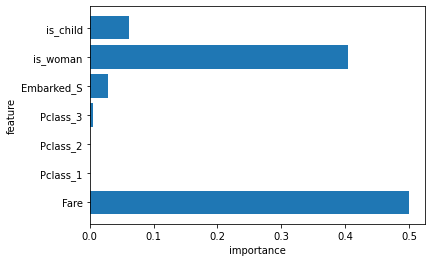

In [75]:
from libs.simpleplotter import feature_importance

feature_importance(model, X_train)

# Generating Model Predictions For Test Data & Saving the results for Kaggle Competition

In [ ]:
y_test = model.predict(XTEST)
output = pd.DataFrame({'PassengerId': PassengerColumn, 'Survived': y_test})
output.to_csv('./submission.csv', index=False)
SUBMISSION = pd.read_csv("./submission.csv")
SUBMISSION